This notebook implements and explores adaOSB on the two dimensional example and critically shows
1. The ellipsoid sampler that can be used with Gaussian noise in lower dimensional settings
2. Non-QR max quantile estimation. Since for this example, we have a closed form solution for the LLR, for any given $\boldsymbol x$, we can estimate $Q_{\boldsymbol x}(1 - \alpha)$ to arbitrary precision

This notebook also analyzes data generated in parallel from `./parallel_scripts/coverage_2d.py`. We look at two scenarios, one with $\alpha = 0.32$ and the other with $\alpha = 0.05$.

This notebook also looks at the $\gamma/\eta$ trade-off.

The data generating process is as follows. In $\mathbb{R}^2$, we observe
\begin{equation}
    \boldsymbol y = \boldsymbol x + \varepsilon
\end{equation}
where $\boldsymbol x \geq \boldsymbol 0$, and $\varepsilon \sim N(\boldsymbol 0, \boldsymbol I)$. The quantity of interest for which we estimate a confidence interval is $\theta(\boldsymbol x) = \boldsymbol h^T \boldsymbol x$, where $\boldsymbol h^T = \begin{pmatrix} 1 & -1 \end{pmatrix}$. Finally for the purpose of example, we assume that the true parameter $\boldsymbol x^* = \begin{pmatrix} 0.5 & 0.5 \end{pmatrix}^T$. For this true parameter value, we know that $\chi^2_1$ quantiles provide valid intervals.

In [1]:
from adaFuncCI.utils import int_cover
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from tqdm.notebook import tqdm

In [2]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 18})
plt.rcParams['text.usetex'] = True

# Define the LaTeX preamble to include multiple packages
plt.rcParams['text.latex.preamble'] = r'''
\usepackage{amsmath}
\usepackage{amssymb}
\usepackage{bm}
'''

# Algorithm Steps Separated out

## 1 - Generate Data

In [3]:
# set fixed experiment settings
x_star = np.array([0.5, 0.5])
h = np.array([1, -1])
noise_distr = stats.norm
N = 1000  # number of data draws

# uncertainty parameters
alpha = 0.32
eta = 0.01
# gamma = (alpha - eta) / (1 - eta)  # old setting
gamma = alpha - eta
print(gamma)

0.31


In [4]:
# generate noise
np.random.seed(213)
noise = noise_distr.rvs(size=(N, 2))
data = x_star + noise

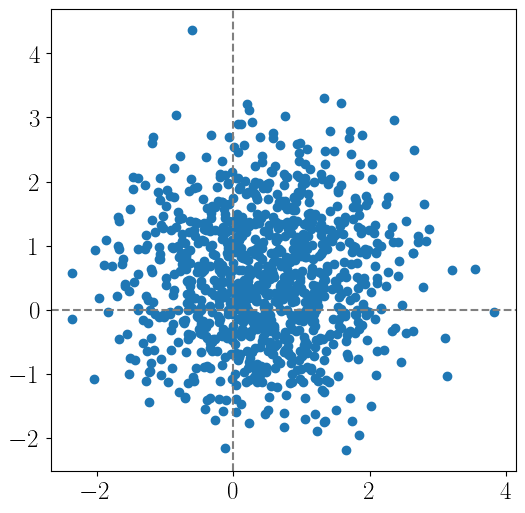

In [5]:
plt.figure(figsize=(6, 6))
plt.scatter(data[:, 0], data[:, 1])
plt.axvline(0, linestyle='--', color='gray')
plt.axhline(0, linestyle='--', color='gray')
plt.show()

## 2 - Explore Samples in Pre-images

In [6]:
from adaFuncCI.sample import ellipsoidSampler

In [7]:
M = 1000
sampler = ellipsoidSampler(K=np.identity(2), Sigma=np.identity(2), y=data[0], eta=eta)
sampler.sample_parameters(M=M, random_seed=3).shape

(1000, 2)

In [8]:
# create the sampler objects for the first four data draws
ell_samplers = [
    ellipsoidSampler(K=np.identity(2), Sigma=np.identity(2), y=data[i], eta=eta)
    for i in range(4)
]

In [9]:
# draw some parameters
M = 1000
param_draws = [
    ell_samplers[i].sample_parameters(M=M, random_seed=i) for i in range(4)
]

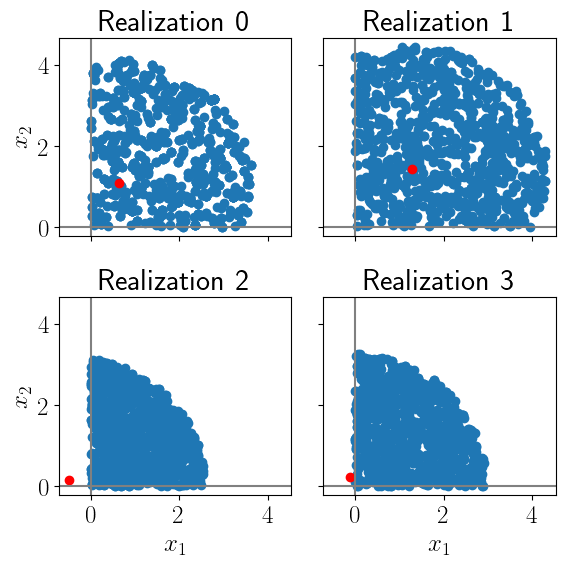

In [10]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6, 6), sharex=True, sharey=True)
for i in range(4):
    ax[i//2, i % 2].scatter(param_draws[i][:, 0], param_draws[i][:, 1])
    ax[i//2, i % 2].scatter([data[i, 0]], [data[i, 1]], color='red')
    ax[i//2, i % 2].axvline(0, color='gray')
    ax[i//2, i % 2].axhline(0, color='gray')
    ax[i//2, i % 2].set_title(f'Realization {i}')
    
ax[0, 0].set_ylabel(r'$x_2$')
ax[1, 0].set_ylabel(r'$x_2$')
ax[1, 0].set_xlabel(r'$x_1$')
ax[1, 1].set_xlabel(r'$x_1$')
plt.tight_layout()
plt.show()

## 3 - Estimate Quantiles

In [11]:
from adaFuncCI.max_quantile import maxQuantileRS
from adaFuncCI.llr import llrSolver_2d

In [12]:
# create objects
llr_2d = llrSolver_2d()
max_q_rs = maxQuantileRS(
    X_train=param_draws[0],
    llr_solver=llr_2d,
    distr=stats.norm,
    q=gamma,
    disable_tqdm=False
)

In [13]:
# estimate max quantile over ensemble
max_q_rs.estimate(num_samp=10000, random_seeds=np.arange(M))

100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [01:22<00:00, 12.07it/s]


1.0731525597988942

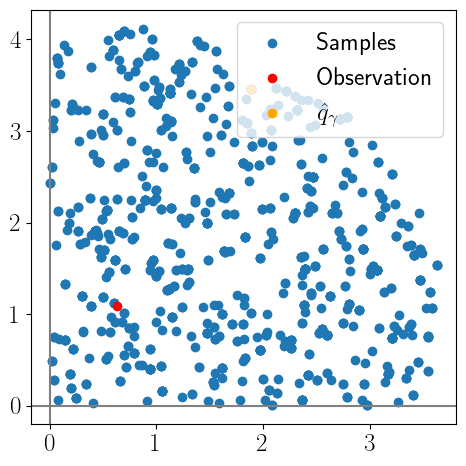

In [14]:
# plot the above at its location
max_loc = max_q_rs.max_quantiles.argmax()
plt.figure(figsize=(5, 5))
plt.scatter(param_draws[0][:, 0], param_draws[0][:, 1], label='Samples')
plt.scatter([data[0, 0]], [data[0, 1]], color='red', label='Observation')
plt.scatter([param_draws[0][max_loc, 0]], [param_draws[0][max_loc, 1]], color='orange', label=r'$\hat{q}_\gamma$')
plt.axvline(0, color='gray')
plt.axhline(0, color='gray')
plt.legend()
plt.tight_layout()
plt.show()

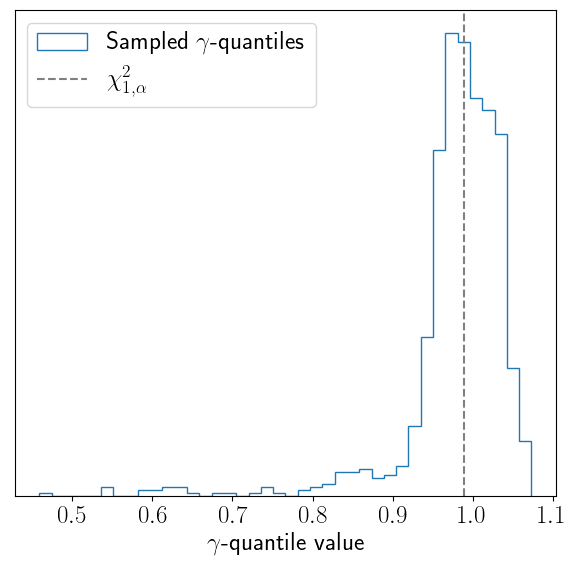

In [15]:
# look at distribution of quantiles
plt.figure(figsize=(6, 6))
plt.hist(max_q_rs.max_quantiles, bins=40, histtype='step', density=True, label=r'Sampled $\gamma$-quantiles')
plt.axvline(stats.chi2(1).ppf(0.68), linestyle='--', color='gray', label=r'$\chi^2_{1, \alpha}$')
plt.yticks([])
plt.xlabel('$\gamma$-quantile value')
plt.legend()
plt.tight_layout()
plt.show()

#### Fit intervals

We fit five intervals
1. MQ Direct
2. MQ Optimized
3. MQ$\mu$ Param
4. MQ$\mu$ Func
5. OSB

In [16]:
from adaFuncCI.inversion_intervals import solve_llr_fixed_y
from adaFuncCI.inversion_intervals import direct_inversion
from adaFuncCI.inversion_intervals import max_local_quantile_inversion
from adaFuncCI.optimize import osb_int
import pandas as pd

In [17]:
# solve for the LLR at each sampled functional value
llr_vals_qoi_test = solve_llr_fixed_y(
    qoi_vals=param_draws[0] @ h,
    y=data[0],
    K=np.identity(2),
    h=h,
    disable_tqdm=False
)

100%|████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.50it/s]


In [18]:
arg_sort = np.argsort(param_draws[0] @ h)
qoi_vals_sort = (param_draws[0] @ h)[arg_sort].copy()
llr_vals_sort = llr_vals_qoi_test[arg_sort].copy()
q_hat_vals_sort = max_q_rs.max_quantiles[arg_sort].copy()

# smooth
T = 10
q_hat_series = pd.Series(q_hat_vals_sort)
max_q_pred = q_hat_series.rolling(T, center=True).max().dropna()
q_hat_vals_sort = q_hat_vals_sort[T - 1:].copy()
llr_vals_sort = llr_vals_sort[T - 1:].copy()
qoi_vals_sort = qoi_vals_sort[T - 1:].copy()

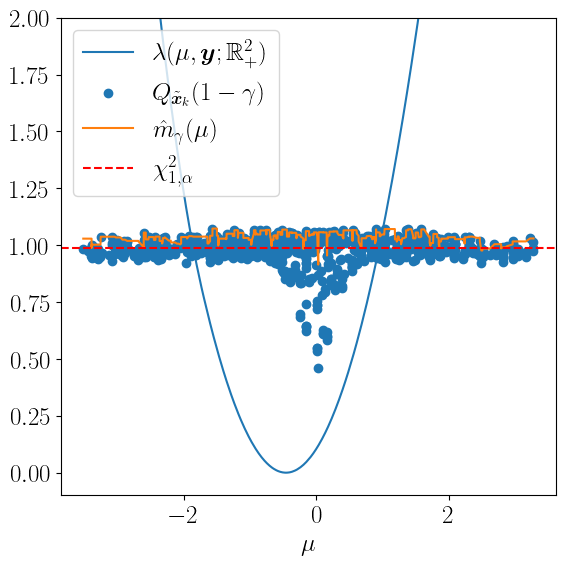

In [19]:
plt.figure(figsize=(6, 6))
plt.plot(qoi_vals_sort, llr_vals_sort, label=r'$\lambda(\mu, \bm{y}; \mathbb{R}^2_+)$')#, label=r'$\lambda(\mu, \bm{y}; \mathbb{R}^2_+)$')
plt.scatter(qoi_vals_sort, q_hat_vals_sort, label=r'$Q_{\tilde{\bm{x}}_k}(1 - \gamma)$')
plt.plot(qoi_vals_sort, max_q_pred, label=r'$\hat{m}_\gamma(\mu)$')
plt.axhline(stats.chi2(1).ppf(0.68), color='red', linestyle='--', label=r'$\chi^2_{1, \alpha}$')
# plt.ylabel(r'$\lambda(\mu, y; \mathbb{R}^2_+)$')
plt.xlabel(r'$\mu$')
plt.ylim(-0.1, 2)

plt.legend()
plt.tight_layout()
plt.show()

In [20]:
# --- MQ direct
mq_direct = direct_inversion(
    qoi_vals=param_draws[0] @ h,
    llr_vals_qoi=llr_vals_qoi_test,
    q_hat_vals=max_q_rs.max_quantiles,
    local=False
)

# --- MQ Opt
mq_opt = osb_int(y=data[0], q=max_q_rs.max_quantiles.max(), K=np.identity(2), h=h)

# --- MQmu param
mq_mu_param = direct_inversion(
    qoi_vals=param_draws[0] @ h,
    llr_vals_qoi=llr_vals_qoi_test,
    q_hat_vals=max_q_rs.max_quantiles,
    local=True
)

# --- MQmu func
mq_mu_func = max_local_quantile_inversion(
    qoi_vals=param_draws[0] @ h,
    llr_vals_qoi=llr_vals_qoi_test,
    q_hat_vals=max_q_rs.max_quantiles,
    method='rolling',
    hyperparams={'T': 10, 'center': True}
)[0]

# --- OSB Interval
osb = osb_int(y=data[0], q=stats.chi2(1).ppf(1 - alpha), K=np.identity(2), h=h)

In [21]:
print('--- Intervals ---')
print(f'MQ Direct : ({mq_direct[0]:.2f}, {mq_direct[1]:.2f})')
print(f'MQ Opt    : ({mq_opt[0]:.2f}, {mq_opt[1]:.2f})')
print(f'MQmu Param: ({mq_mu_param[0]:.2f}, {mq_mu_param[1]:.2f})')
print(f'MQmu Func : ({mq_mu_func[0]:.2f}, {mq_mu_func[1]:.2f})')
print(f'OSB       : ({osb[0]:.2f}, {osb[1]:.2f})')

--- Intervals ---
MQ Direct : (-1.91, 1.00)
MQ Opt    : (-1.91, 1.01)
MQmu Param: (-1.86, 0.97)
MQmu Func : (-1.89, 0.97)
OSB       : (-1.86, 0.95)


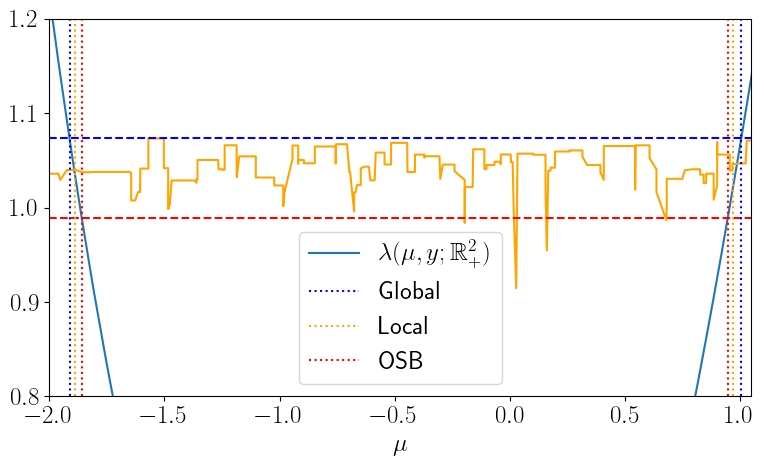

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(qoi_vals_sort, llr_vals_sort, label='$\lambda(\mu, y; \mathbb{R}^2_+)$')
plt.plot(qoi_vals_sort, max_q_pred, color='orange')
plt.axhline(stats.chi2(1).ppf(0.68), color='red', linestyle='--',)
plt.axhline(max_q_pred.max(), color='blue', linestyle='--')

# plot the intervals
for i in range(2):
    plt.axvline(mq_opt[i], linestyle=':', color='blue', label='Global' if i == 0 else None)
    plt.axvline(mq_mu_func[i], linestyle=':', color='orange', label='Local' if i == 0 else None)
    plt.axvline(osb[i], linestyle=':', color='red', label='OSB' if i == 0 else None)

plt.xlabel(r'$\mu$')
plt.ylim(0.8, 1.2)
plt.xlim(-2.0, 1.05)
plt.legend()
plt.tight_layout()
plt.show()

## 4 - Estimate oracle quantile

#### $\alpha = 0.32$

In [28]:
max_q_oracle = maxQuantileRS(
    X_train=param_draws[0],
    llr_solver=llr_2d,
    distr=stats.norm,
    q=alpha,
    disable_tqdm=False
)

In [29]:
# estimate 1-alpha quantile at one point
est_q_oracle = max_q_oracle.estimate_quantile(x=x_star, num_samp=20000)
print(est_q_oracle)

0.6745736669462227


#### $\alpha = 0.05$

In [30]:
max_q_oracle_05 = maxQuantileRS(
    X_train=param_draws[0],
    llr_solver=llr_2d,
    distr=stats.norm,
    q=0.05,
    disable_tqdm=False
)

In [31]:
# estimate 1-alpha quantile at one point
est_q_oracle_05 = max_q_oracle_05.estimate_quantile(x=x_star, num_samp=20000)
print(est_q_oracle_05)

2.9605406312011358


# Analyze Parallel output

Namely, we analyze the output from `./parallel_scripts/coverage_2d.py`.

In [23]:
from statsmodels.stats.proportion import proportion_confint

In [24]:
# make key for interval types
interval_type_key = {
    0: "Global Inverted",
    1: "Global Optimized",
    2: "Sliced Inverted",
    3: "Sliced Optimized",
    4: "OSB"
}

#### $\alpha = 0.32$

In [25]:
# read in the computed quantiles
FILE_NM = 'inverted_ints_numObs_1000_num_param_1000_num_quant_10000_alpha0.32_eta0.01_bbcalib_center_roll.npz'
with open(
    './data/2d_experiments/' + FILE_NM,
    'rb'
) as f:
    exp_obj = np.load(f)
    exp_intervals = exp_obj['intervals']
    exp_qoi_vals = exp_obj['qoi_vals']
    exp_llr_vals = exp_obj['llr_vals']

In [26]:
# number of observations
NUM_OBS = exp_intervals.shape[0]
NUM_INTS = exp_intervals.shape[1]

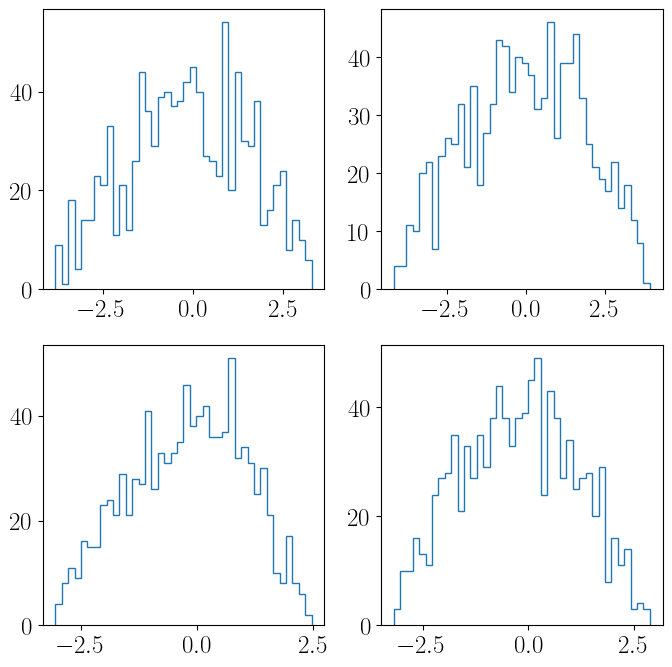

In [27]:
# look at some of the functional distributions
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(8, 8))
for i in range(4):
    ax[i // 2, i % 2].hist(exp_qoi_vals[i], bins=40, histtype='step')

#### Length

In [28]:
interval_lengths = exp_intervals[:, :, 1] - exp_intervals[:, :, 0]

for i in range(exp_intervals.shape[1]):
    print(f'{interval_type_key[i]}: Estimated Length: {interval_lengths.mean(axis=0)[i]}')

Global Inverted: Estimated Length: 2.3850840742648867
Global Optimized: Estimated Length: 2.417355416861864
Sliced Inverted: Estimated Length: 2.2921285905259072
Sliced Optimized: Estimated Length: 2.315841175347294
OSB: Estimated Length: 2.2509428538551153


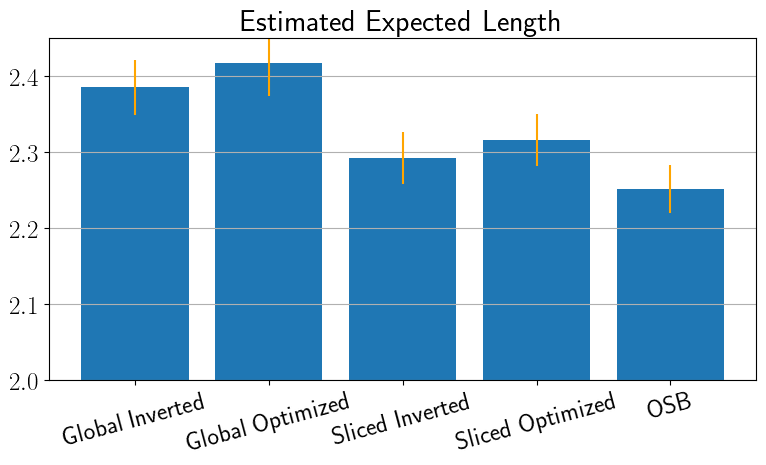

In [29]:
plt.figure(figsize=(8, 5))
plt.grid(True, axis='y')

plt.bar(x=np.arange(5), height=interval_lengths.mean(axis=0))
plt.vlines(
    x=np.arange(5),
    ymin=interval_lengths.mean(axis=0) - stats.norm.ppf(0.975) * (interval_lengths.std(axis=0) / np.sqrt(NUM_OBS)),
    ymax=interval_lengths.mean(axis=0) + stats.norm.ppf(0.975) * (interval_lengths.std(axis=0) / np.sqrt(NUM_OBS)),
    color='orange'
)

plt.xticks(ticks=np.arange(5), labels=[interval_type_key[i] for i in range(5)], rotation=15)
plt.ylim(2.0, 2.45)
plt.title('Estimated Expected Length')
plt.tight_layout()
plt.show()

#### Coverage

In [30]:
# compute coverage
coverage = np.zeros(shape=(NUM_OBS, NUM_INTS))
for i in range(NUM_OBS):
    for j in range(NUM_INTS):
        coverage[i, j] = int_cover(mu_true=0, interval=exp_intervals[i, j, :])
        
for i in range(NUM_INTS):
    print(f'{interval_type_key[i]}: Estimated Coverage: {coverage.mean(axis=0)[i]}')

Global Inverted: Estimated Coverage: 0.785
Global Optimized: Estimated Coverage: 0.785
Sliced Inverted: Estimated Coverage: 0.768
Sliced Optimized: Estimated Coverage: 0.772
OSB: Estimated Coverage: 0.765


In [31]:
coverage_cis = np.zeros(shape=(NUM_INTS, 2))
for i in range(NUM_INTS):
    coverage_cis[i, :] = proportion_confint(
        coverage.mean(axis=0)[i] * NUM_OBS, NUM_OBS, alpha=0.05, method='beta'
    )
print(coverage_cis)

[[0.75821683 0.81009335]
 [0.75821683 0.81009335]
 [0.74057017 0.79384186]
 [0.74471682 0.79767127]
 [0.73746233 0.79096764]]


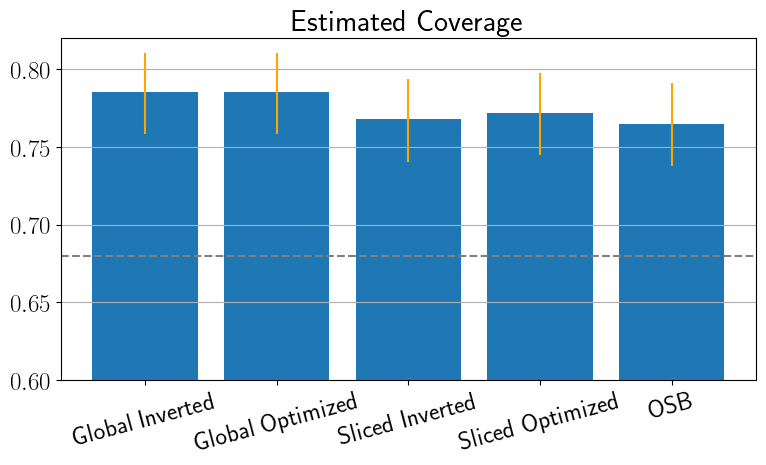

In [32]:
plt.figure(figsize=(8, 5))
plt.grid(True, axis='y')
plt.bar(x=np.arange(5), height=coverage.mean(axis=0))

plt.vlines(x=np.arange(5), ymin=coverage_cis[:, 0], ymax=coverage_cis[:, 1], color='orange')

plt.xticks(ticks=np.arange(5), labels=[interval_type_key[i] for i in range(5)], rotation=15)
plt.axhline(0.68, linestyle='--', color='gray')
plt.title('Estimated Coverage')
plt.ylim(0.6, 0.82)
plt.tight_layout()
plt.show()